## Exploratory Data Analysis (EDA)

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump
import phik
from phik.report import plot_correlation_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from utils import (
    specify_data_types,
    check_class_dist,
    check_datasets_overlap,
    plot_nans_counts,
    plot_data_sizes_by_date,
    calc_percent_per_over_time,
    plot_num_col_histograms,
    remove_cols_with_nans,
    plot_num_cols_dist_by_class,
    plot_num_cols_density_by_class,
    plot_num_cols_dist,
    plot_non_nans_count_over_time,
    plot_num_cols_corr_heatmap,
    calc_cat_cols_cardinality,
    prepare_data,
)
from utils import ModelEvaluator

### Specify data source and column names

In [2]:
#################################
# Specify datastore and dataset names, version, and class label
dataset_name = "bena345/diabetes-readmission"

# Specify column names
class_label_col_name = "Diabetes_binary"
time_series_col_name = None
primary_key_col_name = ["ID"]

# Specify feature types as defined in data source
date_col_names = []
datetime_col_names = []
num_col_names = ["BMI", "PhysHlth"]
cat_col_names = [
    "Age",
    "HighBP",
    "HighChol",
    "CholCheck",
    "Smoker",
    "Stroke",
    "HeartDiseaseorAttack",
    "PhysActivity",
    "Fruits",
    "Veggies",
    "HvyAlcoholConsump",
    "AnyHealthcare",
    "NoDocbcCost",
    "GenHlth",
    "MentHlth",
    "DiffWalk",
    "Sex",
    "Education",
    "Income",
]

# Exclude columns from categorical features
selected_feature_names = num_col_names + cat_col_names

# Specify columns for correlation analysis
# Note: columns considered for bivariate analysis should those that can be used for model training
# only, i.e., features that can cause data leakage should be excluded.
corr_selected_cols = num_col_names + cat_col_names

# Specify threshold for removing feature due to high missing values
# Note: 1 means don't drop columns with missing values.
threshold_val_for_nans_exclusion = 1

# Specify threshold for max. number of categories per categorical feature
max_num_categories_per_cat_col_thresh = 250

# Specify the number of hashed categorical features (it needs to be tuned)
transformed_hashed_cat_features_count = 200

# Specify folder to save EDA plots and files
eda_figs_dir = ".eda_figures/"
if not os.path.exists(eda_figs_dir):
    os.makedirs(eda_figs_dir)

### Import training dataset

In [3]:
train_set = pd.read_parquet(
    f"{os.path.abspath('..')}/src/feature_store/feature_repo/data/train.parquet"
)

test_set = pd.read_parquet(
    f"{os.path.abspath('..')}/src/feature_store/feature_repo/data/test.parquet"
)

### Specify data types and check class distribution

In [4]:
# Select columns to keep in training set (keep column order meaningful)
columns_to_keep = (
    primary_key_col_name
    + date_col_names
    + datetime_col_names
    + selected_feature_names
    + [class_label_col_name]
)
train_set = train_set[columns_to_keep]

# Specify data types
print("\nData types of training set:\n")
train_set = specify_data_types(
    input_data=train_set,
    date_cols_names=date_col_names,
    datetime_cols_names=datetime_col_names,
    numerical_cols_names=num_col_names,
    categorical_cols_names=None,
)

# Select columns to keep in training set (keep column order meaningful)
test_set = test_set[columns_to_keep]

# Specify data types
print("\nData types of testing set:\n")
test_set = specify_data_types(
    input_data=test_set,
    date_cols_names=date_col_names,
    datetime_cols_names=datetime_col_names,
    numerical_cols_names=num_col_names,
    categorical_cols_names=None,
)

# Replace missing values in categorical features with "Unspecified" value
# Note: to avoid getting (AttributeError: 'bool' object has no attribute 'transpose') error
# when transforming train set possibly because of pd.NA, set categorical features as object.
# Specify data types.
train_set[cat_col_names] = train_set[cat_col_names].replace({pd.NA: "Unspecified"})
test_set[cat_col_names] = test_set[cat_col_names].replace({pd.NA: "Unspecified"})


Data types of training set:

Numerical columns:
['BMI', 'PhysHlth']


The following (categorical) columns will be converted to 'object' type.
 ['ID', 'Age', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'DiffWalk', 'Sex', 'Education', 'Income', 'Diabetes_binary']

Data types of testing set:

Numerical columns:
['BMI', 'PhysHlth']


The following (categorical) columns will be converted to 'object' type.
 ['ID', 'Age', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'DiffWalk', 'Sex', 'Education', 'Income', 'Diabetes_binary']


In [5]:
# Check class distributions
class_labels_counts, _ = check_class_dist(
    input_data=train_set, class_col_name=class_label_col_name
)


Dataset class counts:

{'Non-Diabetic': 165933, 'Diabetic': 26863} 

{'Non-Diabetic': 86.07, 'Diabetic': 13.93} 



### Check if training and testing sets overlap by date column

In [6]:
# Check data leakage
check_datasets_overlap(train_set, test_set, primary_key_col_name)

if time_series_col_name is not None:
    plot_data_sizes_by_date(
        first_dataset=train_set,
        second_dataset=test_set,
        date_col_name=time_series_col_name,
        vline_date=test_set[time_series_col_name].min(),
        first_dataset_name="Train Set",
        second_dataset_name="Test Set",
        font_size=12,
        fig_width=1000,
        fig_height=600,
    )


No overlapping samples between the two datasets.



### Check missing values
Remove columns with high percentage of missing values. Imputing missing values for a feature with high % of missing values (e.g., 50%) does not make sense in some cases and can be considered for removal.

In [7]:
# Check missing values
plot_nans_counts(input_data=train_set, fig_size=(24, 24))
plt.savefig(eda_figs_dir + "train_dataset_nans_by_column.png")

# Specify features with high percentage of missing values that should be kept
cols_with_nans_to_keep = [class_label_col_name]

# Display missing values percentage by column after removing columns with missing values greater than threshold_val_for_nans_exclusion
nans_counts_before_removal = train_set.isna().sum()
nans_percent_before_removal = round(
    100 * nans_counts_before_removal / train_set.shape[0], 2
)
print(
    "\nMissing values count by column before removing columns with high missing values:\n",
    nans_percent_before_removal.sort_values(ascending=False),
)

# Remove features with missing values higher than nans_removal_thresh_val
train_set = remove_cols_with_nans(
    input_data=train_set,
    cols_to_keep=cols_with_nans_to_keep,
    thresh_for_exclusion=threshold_val_for_nans_exclusion,
)

# Display missing values percentage by column after removing columns with missing values greater than threshold_val_for_nans_exclusion
missing_values_counts_after_removal = train_set.isna().sum()
missing_values_percentages_after_removal = round(
    100 * missing_values_counts_after_removal / train_set.shape[0], 2
)
print(
    "\nMissing values percentage by column after removing columns with high missing values:\n",
    missing_values_percentages_after_removal.sort_values(ascending=False),
)

# Update training set's features list after removing ones with high missing values
prepped_data_selected_cols = train_set.columns

# Update numerical and categorical features list after removing ones with missing values
num_col_names = [col for col in num_col_names if col in prepped_data_selected_cols]
cat_col_names = [col for col in cat_col_names if col in prepped_data_selected_cols]
print("\nNumerical features in training set:\n", num_col_names)
print("\nCategorical features in training set:\n", cat_col_names)

No missing values found

Missing values count by column before removing columns with high missing values:
 ID                      0.0
Veggies                 0.0
Income                  0.0
Education               0.0
Sex                     0.0
DiffWalk                0.0
MentHlth                0.0
GenHlth                 0.0
NoDocbcCost             0.0
AnyHealthcare           0.0
HvyAlcoholConsump       0.0
Fruits                  0.0
BMI                     0.0
PhysActivity            0.0
HeartDiseaseorAttack    0.0
Stroke                  0.0
Smoker                  0.0
CholCheck               0.0
HighChol                0.0
HighBP                  0.0
Age                     0.0
PhysHlth                0.0
Diabetes_binary         0.0
dtype: float64

Missing values percentage by column after removing columns with high missing values:
 ID                      0.0
Veggies                 0.0
Income                  0.0
Education               0.0
Sex                     0.0
DiffWal

<Figure size 640x480 with 0 Axes>

### Plot class proportions over time

In [8]:
if time_series_col_name is not None:
    # Plot class proportions over time
    proportion_frequency = "Month"  # Can be 'Month', 'Week', or 'Day'
    class_percent_over_time = calc_percent_per_over_time(
        input_data=train_set[[time_series_col_name, class_label_col_name]],
        date_col_name=time_series_col_name,
        class_col_name=class_label_col_name,
        freq=proportion_frequency,
    )

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

    sns.lineplot(
        data=class_percent_over_time,
        x=proportion_frequency,
        y="Class Proportions",
        hue=class_label_col_name,
        ax=ax,
    )
    ax.set(title=f"Class Proportions Per {proportion_frequency}", xlabel=None)
    ax.set_ylim(
        0,
        class_percent_over_time["Class Proportions"].max()
        + (class_percent_over_time["Class Proportions"].max() / 10),
    )
    plt.xticks(rotation=45)
    if proportion_frequency == "Week":
        ax.set_xticks(ax.get_xticks()[::4])
    if proportion_frequency == "Day":
        ax.set_xticks(ax.get_xticks()[::15])
    plt.xlabel(proportion_frequency, fontsize=12)
    plt.ylabel("Class Proportions", fontsize=12)
    plt.savefig(eda_figs_dir + "class_proportions_over_time.png");

### Examine features distributions

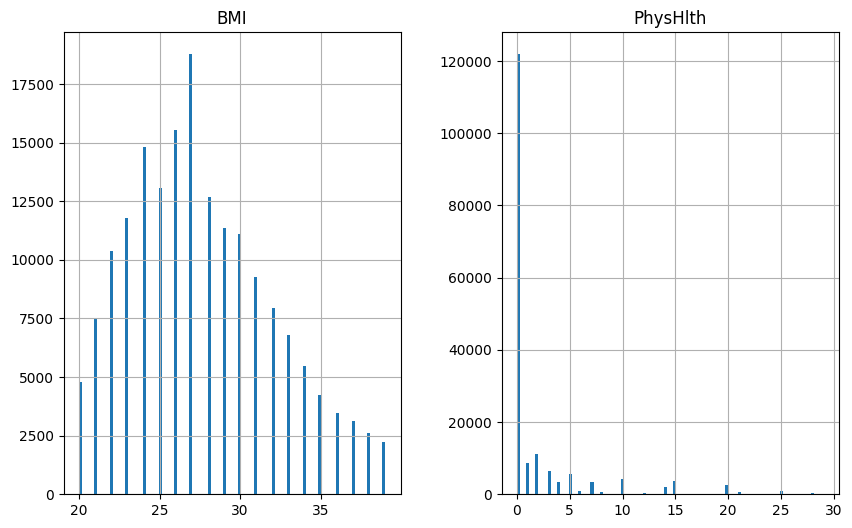

In [9]:
# Plot numerical features distributions
plot_num_col_histograms(
    input_data=train_set,
    num_col_names=num_col_names,
    no_of_bins=100,
    x_axis_label_size=10,
    y_axis_label_size=10,
    figure_size=(10, 6),
    lower_percentile=0.05,
    upper_percentile=0.95,
)
plt.savefig(eda_figs_dir + "num_cols_histograms.png");

/workspaces/end-to-end-tabular-ml/notebooks/utils.py:865: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=x_axis_rot, ha="right")
/workspaces/end-to-end-tabular-ml/notebooks/utils.py:865: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=x_axis_rot, ha="right")
/workspaces/end-to-end-tabular-ml/notebooks/utils.py:865: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=x_axis_rot, ha="right")
/workspaces/end-to-end-tabular-ml/notebooks/utils.py:865: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_

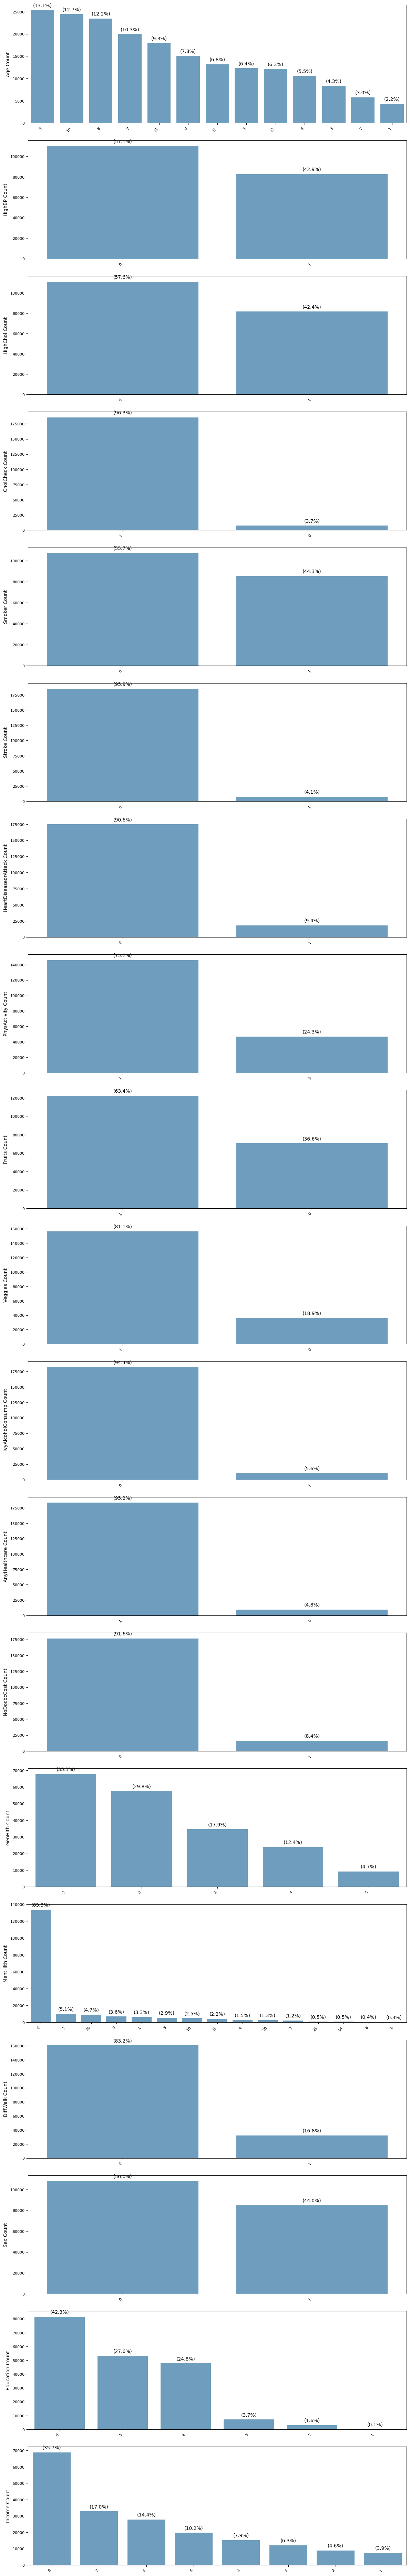

In [10]:
# Plot distributions of categorical features
plot_num_cols_dist(
    input_data=train_set,
    cat_cols_names=cat_col_names,
    top_cat_count=15,
    x_axis_label_size=10,
    y_axis_label_size=10,
    figure_size=(12, 75),
    x_axis_rot=45,
)
plt.savefig(eda_figs_dir + "cat_cols_barplots.png");

### Analyze features distributions over class label

/workspaces/end-to-end-tabular-ml/notebooks/utils.py:694: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/workspaces/end-to-end-tabular-ml/notebooks/utils.py:694: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


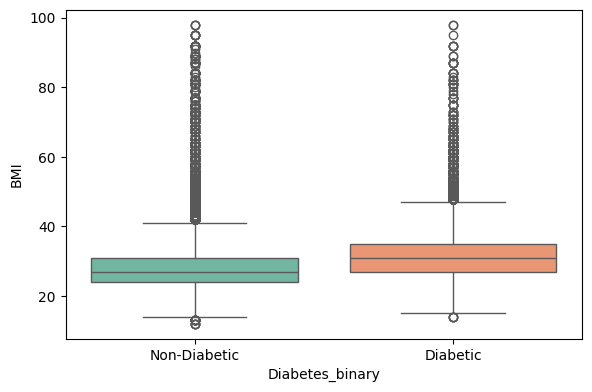

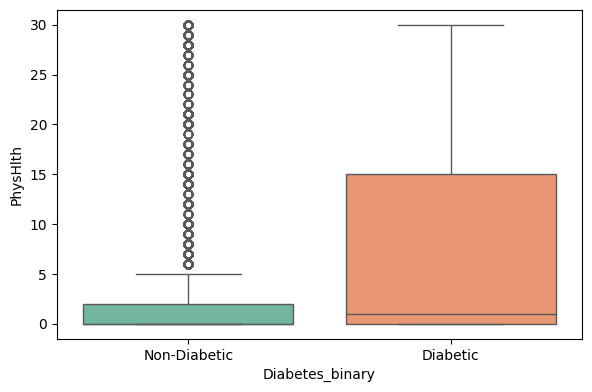

In [11]:
# Plot the distribution of numeric features with respect to binary class label
plot_num_cols_dist_by_class(
    input_data=train_set,
    num_col_names=num_col_names,
    class_col_name=class_label_col_name,
    figure_size=(6, 4),
    box_max_length=1.5,
)
plt.savefig(eda_figs_dir + "num_cols_dist_by_class_values.png");

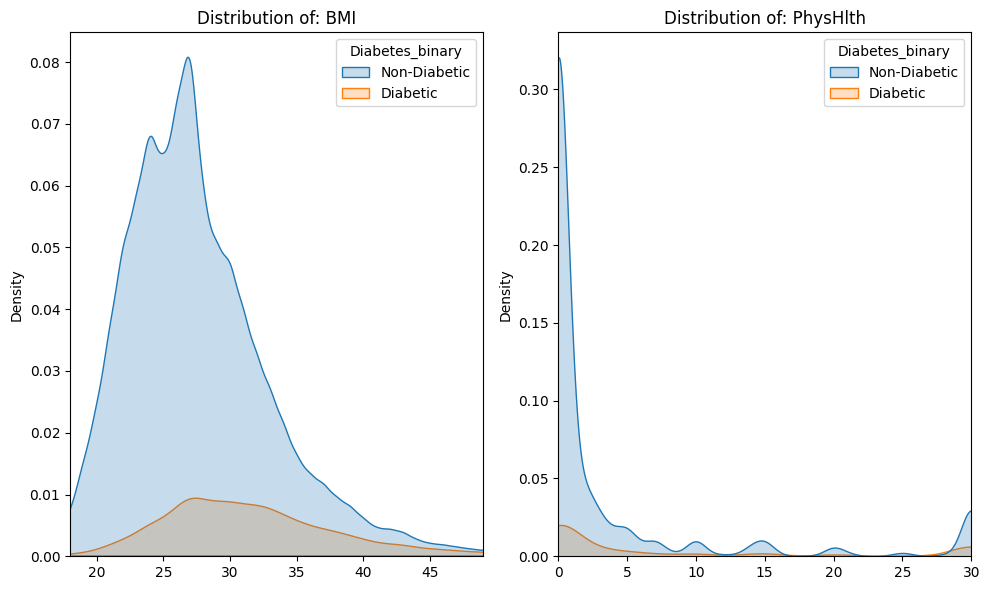

In [12]:
# Plot density of numerical features with respect to binary class class label
# Note: use lower and upper percentiles to exclude outliers and make patterns more visible.
plot_num_cols_density_by_class(
    input_data=train_set,
    num_cols_names=num_col_names,
    class_col_name=class_label_col_name,
    figure_size=(10, 6),
    smooth_function_grid_size=2000,
    lower_percentile=0.01,
    upper_percentile=0.99,
)
plt.savefig(eda_figs_dir + "num_cols_with_class_density.png")

### Examine features continuity over time
This is meant to check if certain columns were populated in source after certain date, which could impact the performance of models. For example, is a column in data source populated continuously over specified date range or column population stopped after certain date).

In [13]:
if time_series_col_name is not None:
    plot_non_nans_count_over_time(
        input_data=train_set,
        col_names=num_col_names,
        date_col_name=time_series_col_name,
        figure_size=(12, 50),
    )
    plt.savefig(
        eda_figs_dir
        + "num_cols_non_missing_values_count_over_"
        + time_series_col_name
        + ".png"
    )

In [14]:
if time_series_col_name is not None:
    plot_non_nans_count_over_time(
        input_data=train_set,
        col_names=cat_col_names,
        date_col_name=time_series_col_name,
        figure_size=(12, 100),
    )
    plt.savefig(
        eda_figs_dir
        + "cat_cols_non_missing_values_count_over_"
        + time_series_col_name
        + ".png"
    )

### Identify categorical features with high cardinality 

In [15]:
high_cardinal_features = calc_cat_cols_cardinality(
    input_data=train_set, cat_col_names=cat_col_names
)
high_cardinal_features.to_csv(eda_figs_dir + "cardinality_by_column.csv", index=False)
print("\nNumber of categories per categorical feature:\n")
high_cardinal_features


Number of categories per categorical feature:



,Categorical Feature Name,Unique Values count
14,MentHlth,31
0,Age,13
18,Income,8
17,Education,6
13,GenHlth,5
3,CholCheck,2
4,Smoker,2
5,Stroke,2
6,HeartDiseaseorAttack,2
7,PhysActivity,2


### Correlation matrices
Pearson's correlation matrix for numerical feature.

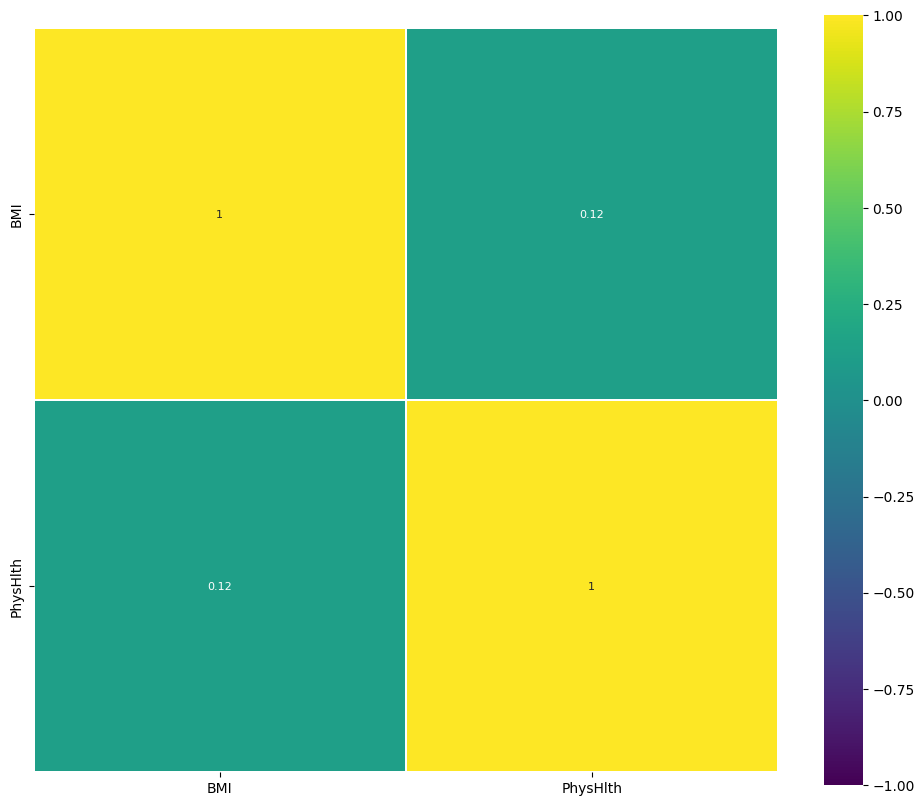

In [16]:
# Plot correlation matrix for numerical features
plot_num_cols_corr_heatmap(
    input_data=train_set,
    num_col_names=num_col_names,
    min_pos_corr_thresh=0,
    min_neg_corr_thresh=-1,
    figure_size=(12, 10),
)
plt.savefig(eda_figs_dir + "num_cols_corr.png")

In [17]:
# Update features list after removing ones with high missing values
high_cardinal_col_names = high_cardinal_features.loc[
    high_cardinal_features["Unique Values count"]
    > max_num_categories_per_cat_col_thresh,
    "Categorical Feature Name",
].tolist()
corr_selected_cols = [
    col
    for col in corr_selected_cols
    if col in prepped_data_selected_cols and col not in high_cardinal_col_names
]

# Select columns for correlations calculation
corr_dataset = train_set[corr_selected_cols + [class_label_col_name]].copy()

# Calculate missing values
missing_values_counts = corr_dataset.isna().sum()
missing_values_percentages = round(
    100 * missing_values_counts / corr_dataset.shape[0], 2
)
missing_values_counts.drop(
    missing_values_counts[missing_values_counts > 0].index, inplace=True
)

# Update numerical features list after removing ones with missing values
corr_matrix_num_col_names = [
    col for col in num_col_names if col in missing_values_counts.index
]
print("\nFeatures to be included in correlation matrix:\n", corr_selected_cols)


Features to be included in correlation matrix:
 ['BMI', 'PhysHlth', 'Age', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'DiffWalk', 'Sex', 'Education', 'Income']


Calculating $\phi_k$ correlation matrix is computationally expensive for large dataset but its main advantage is it can capture non-linear relationship between features.

In [18]:
# Calculate correlation matrix using pairwise phi coefficients
phik_overview = phik.phik.phik_matrix(
    corr_dataset, interval_cols=corr_matrix_num_col_names
)
phik_overview.to_csv(eda_figs_dir + "Phi_k_corr_matrix.csv")
phik_overview = pd.read_csv(eda_figs_dir + "Phi_k_corr_matrix.csv", index_col=0).round(
    2
)

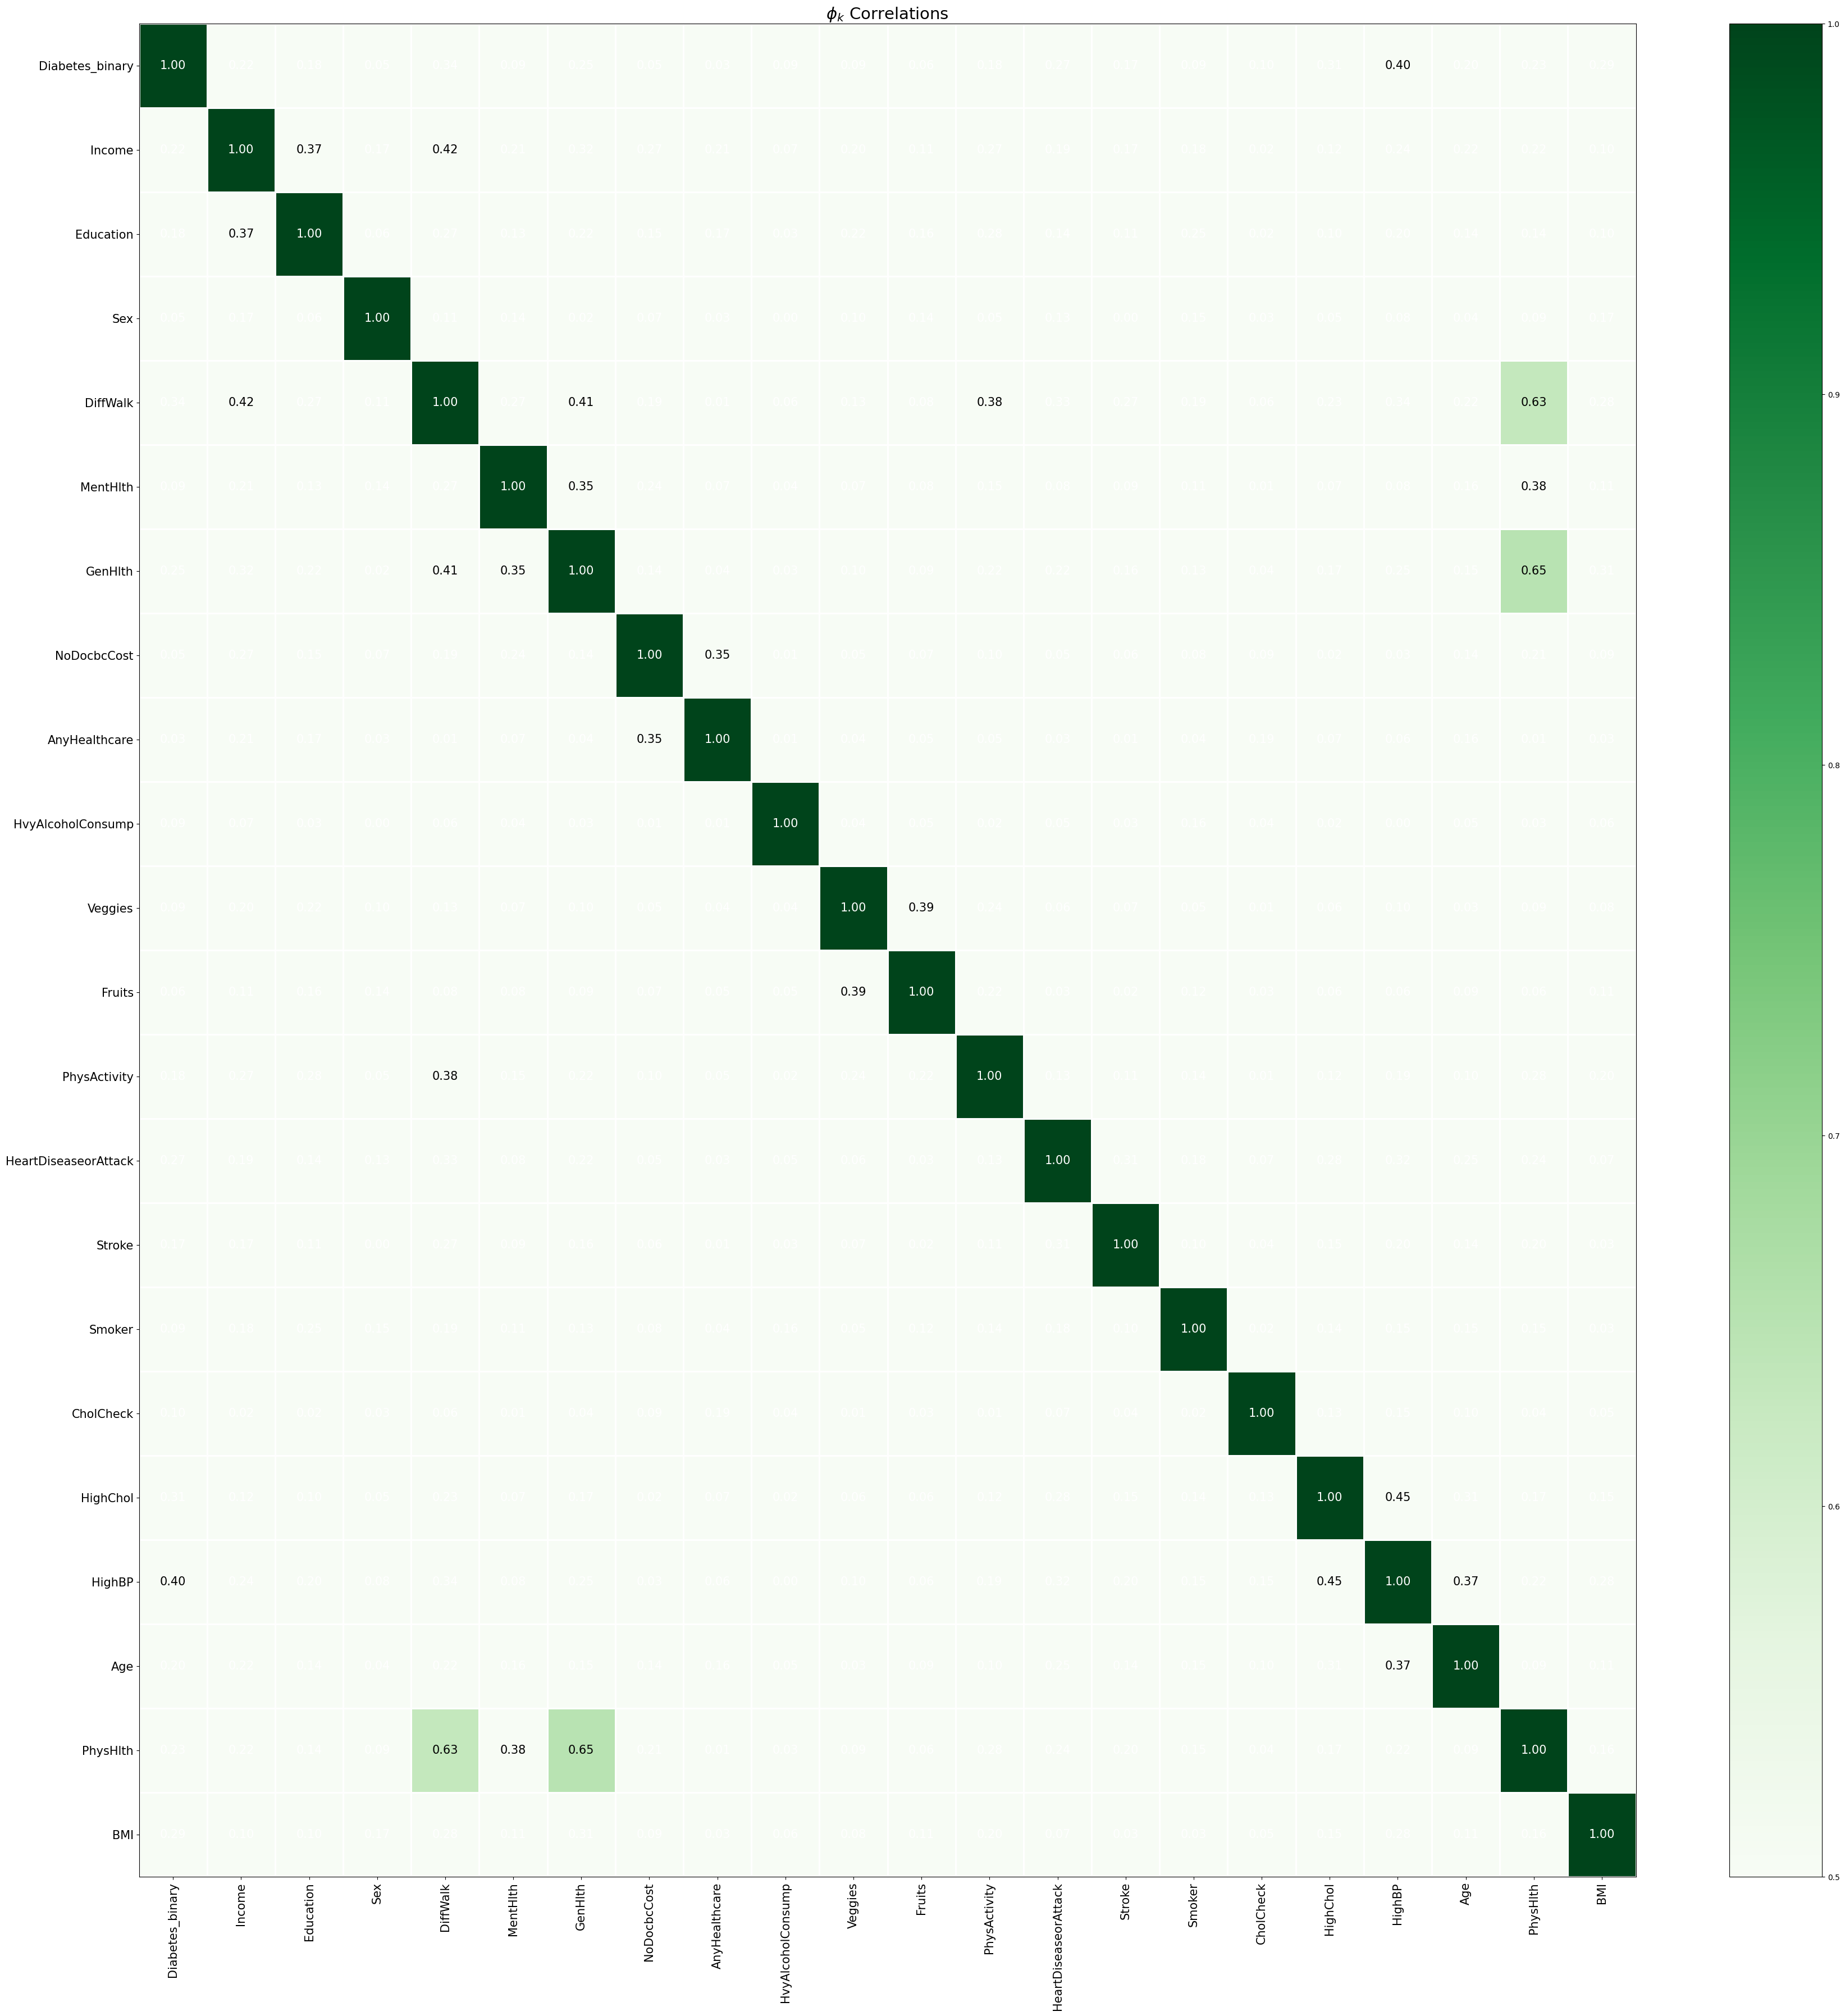

In [19]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0.5,
    vmax=1,
    color_map="Greens",
    title=r"$\phi_k$ Correlations",
    fontsize_factor=1.5,
    figsize=(36, 36),
)
plt.tight_layout()
plt.savefig(eda_figs_dir + "Phi_k_corrs.png")
plt.show()

In [20]:
# Ensure numerical column of correlation matrix of int data type as required by phik.significance.significance_matrix
corr_dataset[corr_matrix_num_col_names] = corr_dataset[
    corr_matrix_num_col_names
].astype("Int64")

# Get the significance matrix (expressed as one-sided Z) of the hypothesis test of each feature-pair
phik_overview_sig_vars = phik.significance.significance_matrix(
    corr_dataset, interval_cols=corr_matrix_num_col_names
)
phik_overview_sig_vars.to_csv(eda_figs_dir + "Phi_k_sig_corrs_matrix.csv")
phik_overview_sig_vars = pd.read_csv(
    eda_figs_dir + "Phi_k_sig_corrs_matrix.csv", index_col=0
).round(2)

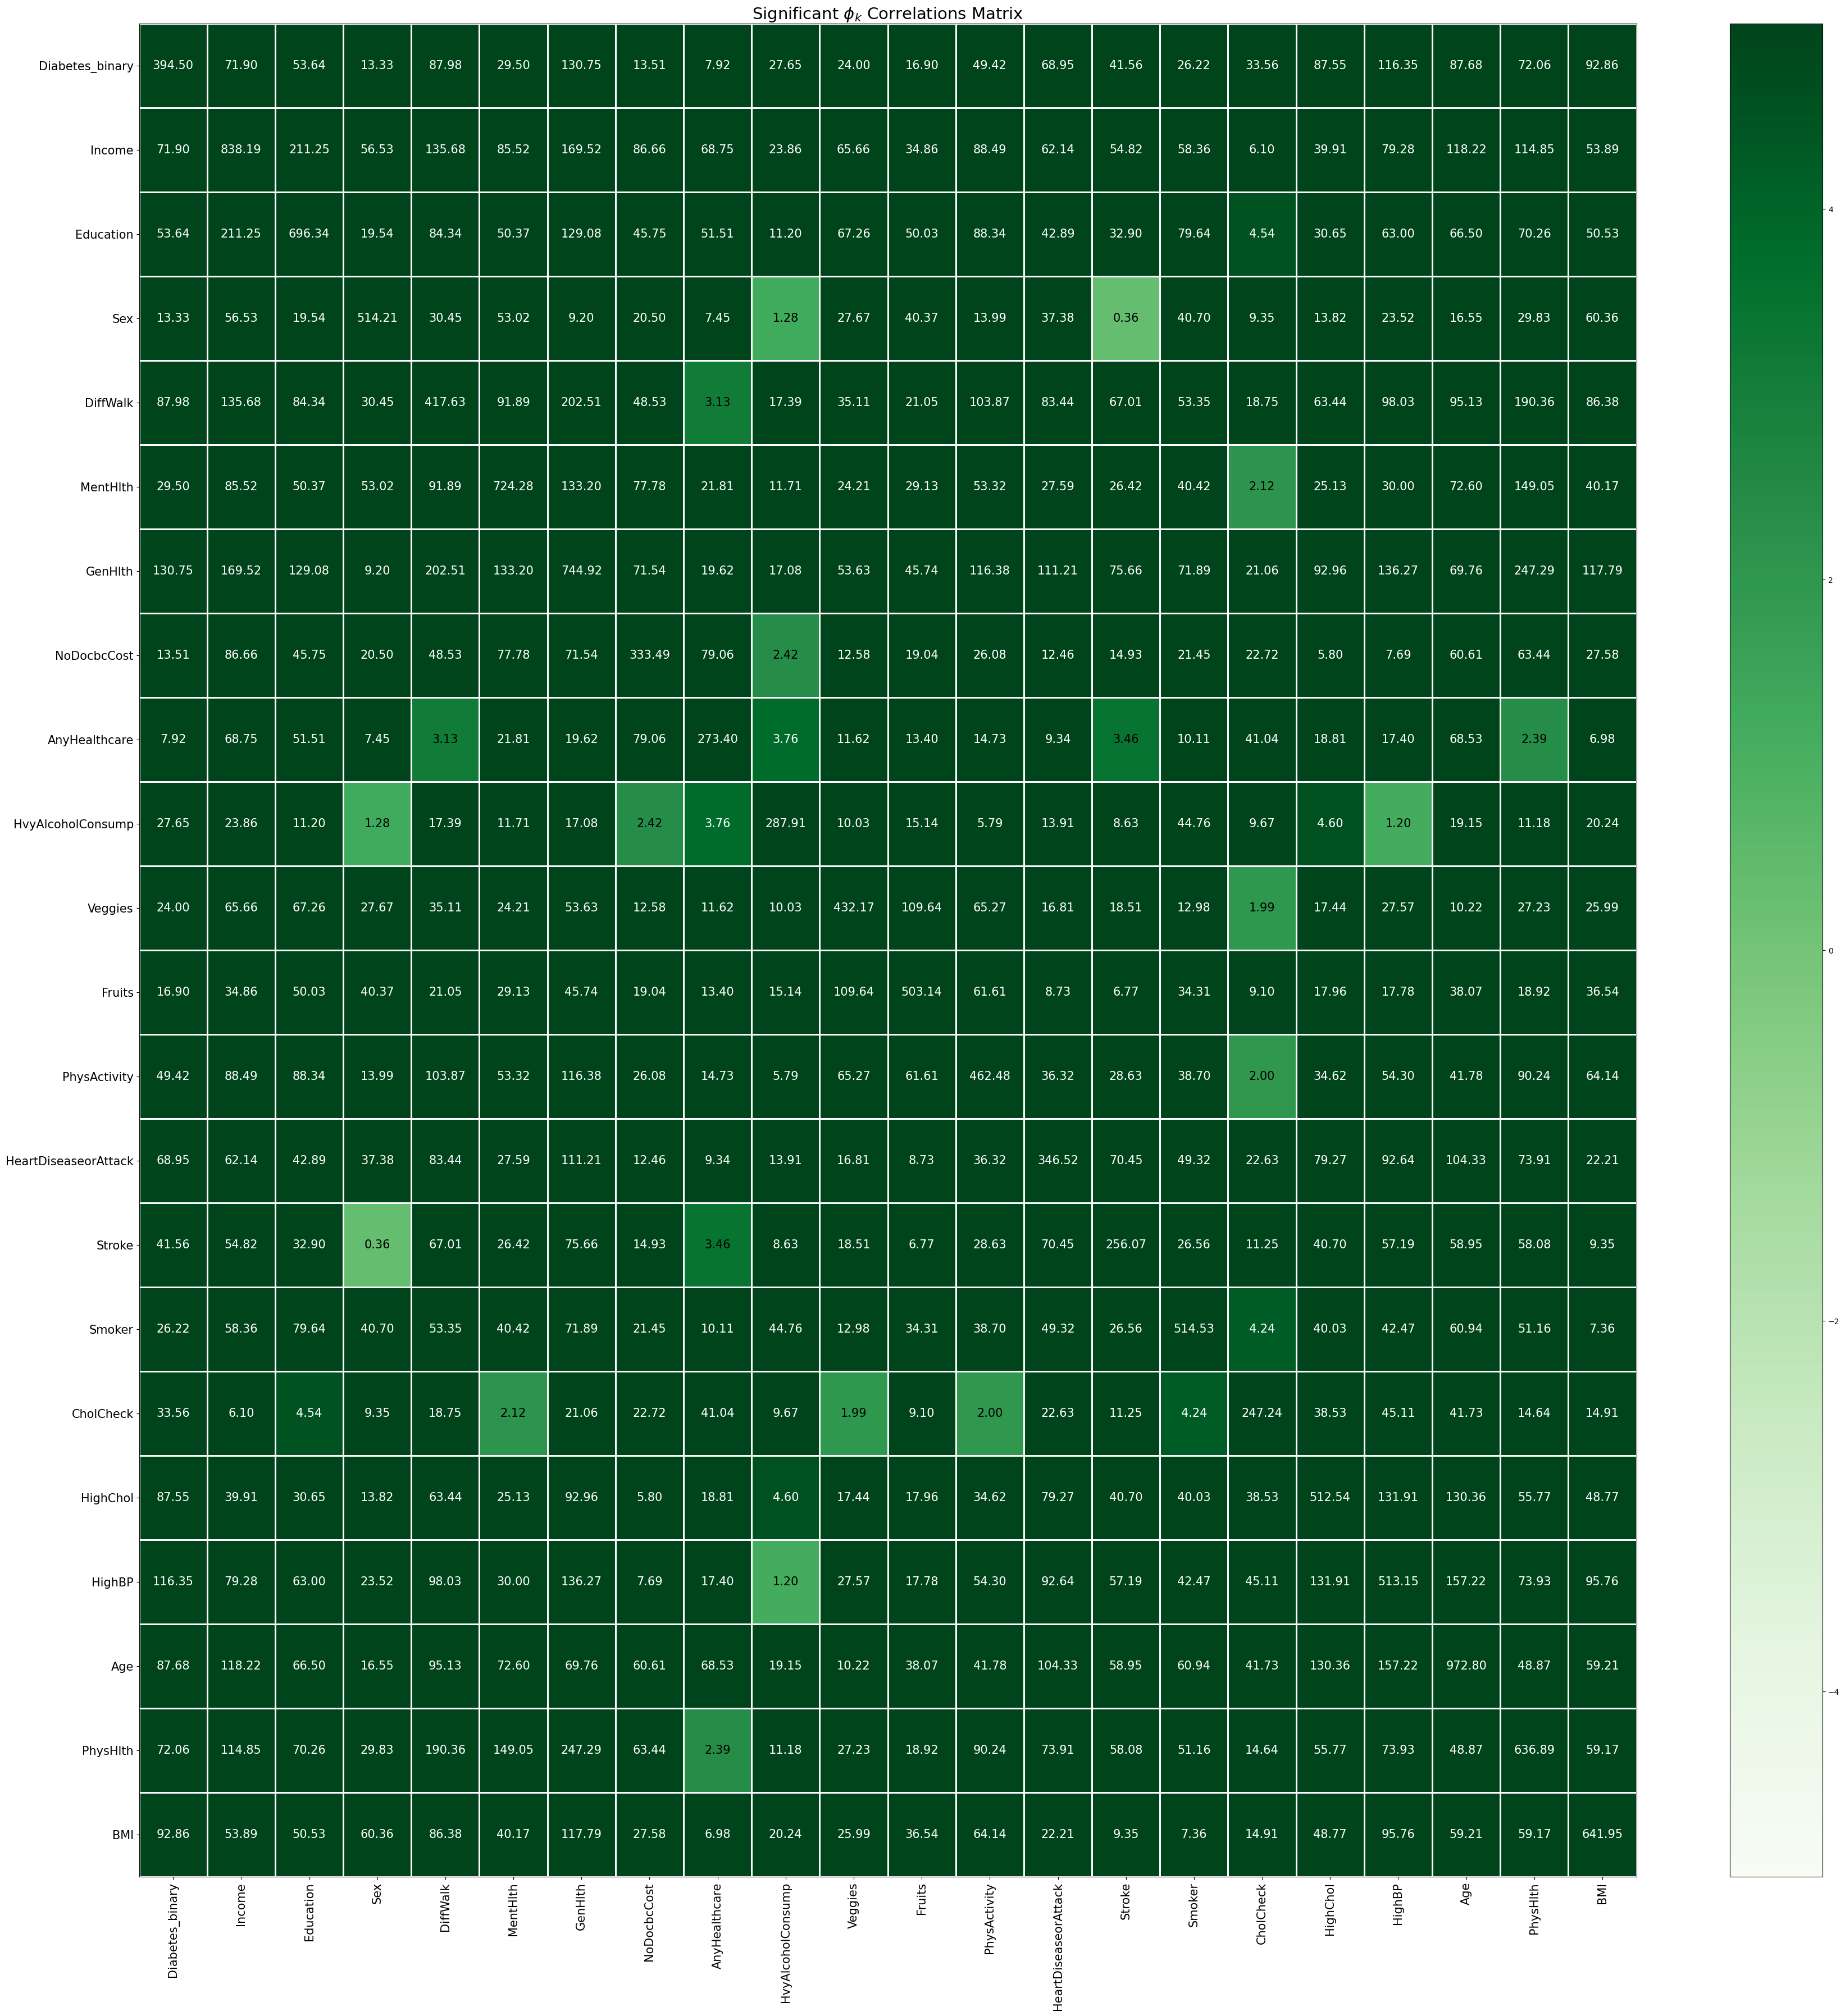

Diabetes_binary,Diabetic,Non-Diabetic
Age,,
1,56,4255
10,5001,19427
11,3909,14031
12,2573,9561
13,2420,10761
2,104,5681
3,237,8120
4,482,10066
5,802,11492


In [21]:
# Higher values indicates significance of correlation coefficient
# Note: authors of phi_k correlation coefficient didn't specify thresholds
# for what constitutes as significant or not other than using subjective
# terms like "very large" or "very significant". Thus, significance here
# should be taken with a grain of salt!
plot_correlation_matrix(
    phik_overview_sig_vars.values,
    x_labels=phik_overview_sig_vars.columns,
    y_labels=phik_overview_sig_vars.index,
    vmin=-5,  # Significance thresholds +/-5
    vmax=5,
    color_map="Greens",
    title=r"Significant $\phi_k$ Correlations Matrix",
    fontsize_factor=1.5,
    figsize=(36, 36),
)
plt.tight_layout()
plt.savefig(eda_figs_dir + "sig_Phi_k_corrs.png")
plt.show()

# Get contingency table of two columns (for testing)
selected_col_class_cols = [list(corr_dataset.columns)[2], class_label_col_name]
display(corr_dataset[selected_col_class_cols].hist2d())

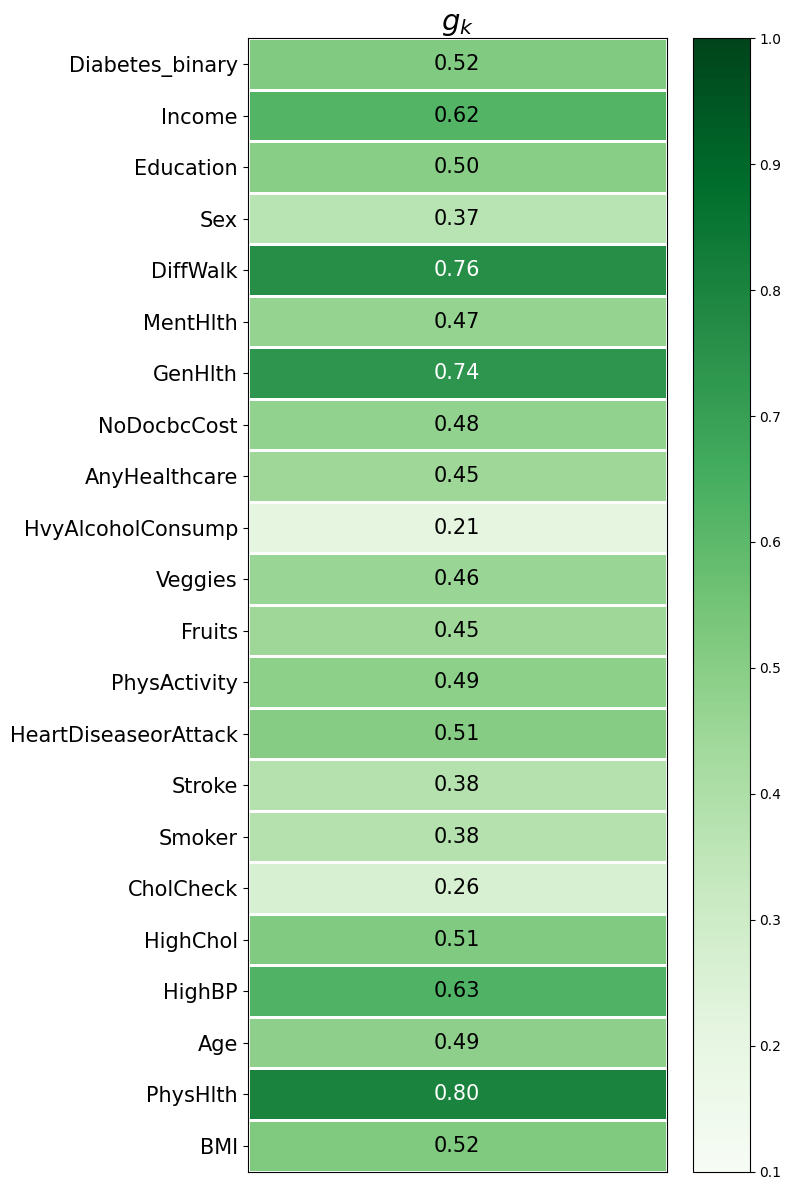

In [22]:
# Global correlations may not be estimated due to error: LinAlgError: SVD did not converge.

# Calculate global correlations, i.e., total correlation of one feature with all other features
global_correlation, global_labels = corr_dataset.global_phik(
    interval_cols=num_col_names
)
global_correlations = pd.DataFrame(
    {"Global Correlations": global_correlation.tolist()}, index=global_labels.tolist()
)
global_correlations.index.name = "Feature"
global_correlations.reset_index(inplace=True)
global_correlations["Global Correlations"] = global_correlations[
    "Global Correlations"
].apply(lambda col: str(col).replace("[", "").replace("]", ""))
global_correlations.to_csv(eda_figs_dir + "Phi_k_global_corrs.csv")
global_correlations = pd.read_csv(
    eda_figs_dir + "Phi_k_global_corrs.csv", index_col=0
).round(2)

plot_correlation_matrix(
    global_correlation,
    x_labels=[""],
    y_labels=global_labels,
    vmin=0.1,
    # vmax = 1,
    figsize=(8, 12),
    color_map="Greens",
    title=r"$g_k$",
    fontsize_factor=1.5,
)
plt.tight_layout()
plt.savefig(eda_figs_dir + "global_corrs.png")
plt.show()

### Baseline model

In [23]:
# Check missing values to determine if percentage of missing values is not too high rendering model fitting unacceptable
baseline_model_train_set = train_set[
    selected_feature_names + [class_label_col_name]
].copy()
plot_nans_counts(input_data=baseline_model_train_set, fig_size=(16, 16));

No missing values found


In [24]:
# Fit Random Forest models for feature importance on training set with binary class
baseline_model = LogisticRegression()

# Prepare data transformation pipeline
train_set_transformed, fitted_model = prepare_data(
    model=baseline_model,
    training_set=baseline_model_train_set,
    train_class_col_name=class_label_col_name,
    numerical_features=num_col_names,
    num_features_simple_imputer="median",
    cat_features_simple_imputer="constant",
    cat_features_ohe_handle_unknown="infrequent_if_exist",
    features_selection_thresh=0.5,
    high_cardinal_cat_features=[],
    output_hashed_cat_features_count=transformed_hashed_cat_features_count,
)

# Save baseline model in artifacts
dump(fitted_model, f"{eda_figs_dir}basline_model.pkl")

# Extract column names of transformed training set with binary class
column_names = train_set_transformed.columns
print("Columns in transformed train set", column_names)

# Encode the labels
class_encoder = LabelEncoder()
training_set_class = class_encoder.fit_transform(
    np.ravel(baseline_model_train_set[[class_label_col_name]])
)
testing_set_class = class_encoder.fit_transform(
    np.ravel(test_set[[class_label_col_name]])
)

/workspaces/end-to-end-tabular-ml/.eda_venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/workspaces/end-to-end-tabular-ml/.eda_venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Columns in transformed train set Index(['BMI', 'PhysHlth'], dtype='object')


### Assess baseline model performance

No. of features including encoded categorical features: 2


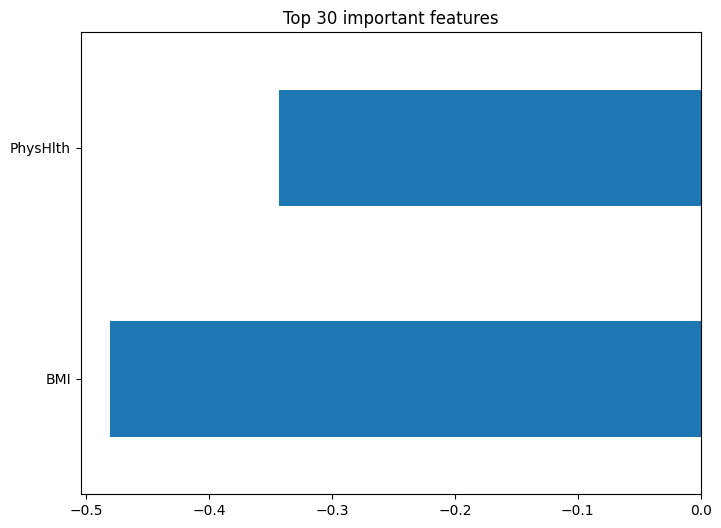

In [25]:
# Get feature importance for best model
# Note: must use uncalibrated_pipeline, as it has feature
# importance attributes.
evaluator = ModelEvaluator(
    pipeline=fitted_model,
    X_train=baseline_model_train_set.drop(columns=[class_label_col_name], axis=1),
    y_train=training_set_class,
    X_test=test_set.drop(columns=[class_label_col_name], axis=1),
    y_test=testing_set_class,
    fbeta_score_beta=0.5,
)

evaluator.extract_feature_importance(
    pipeline=fitted_model,
    num_feature_names=num_col_names,
    cat_feature_names=cat_col_names,
    figure_size=(8, 6),
    font_size=10,
)


Training Score:

        Metric     Score
0     accuracy  0.858685
1    precision  0.863888
2       recall  0.992123
3           f1  0.923576
4  f_0.5_score  0.886813
5      roc_auc  0.513279

Testing Score:

        Metric     Score
0     accuracy  0.858548
1    precision  0.864123
2       recall  0.991563
3           f1  0.923467
4  f_0.5_score  0.886921
5      roc_auc  0.514245


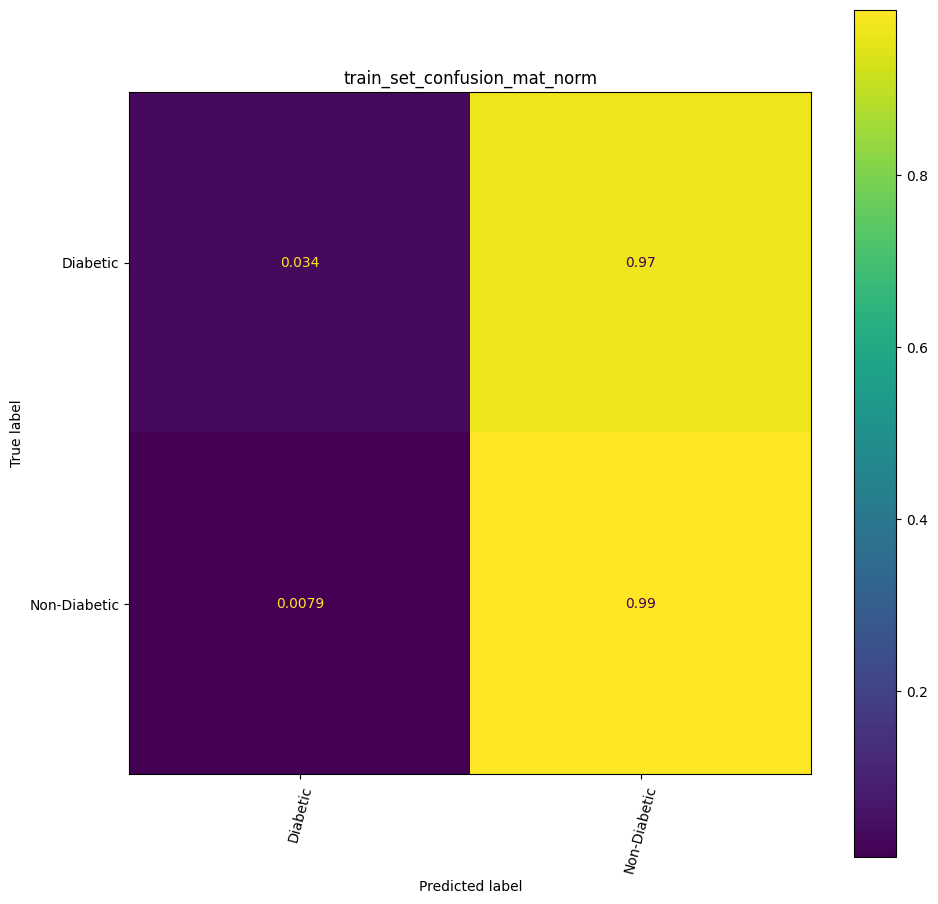

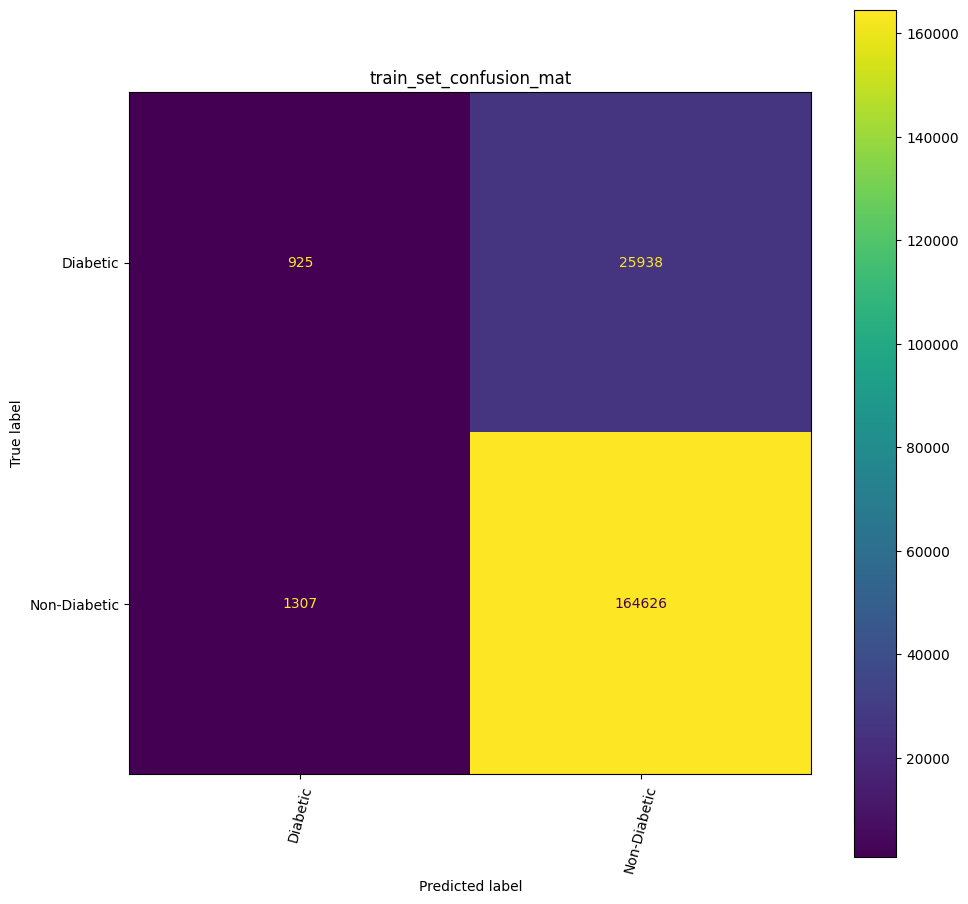

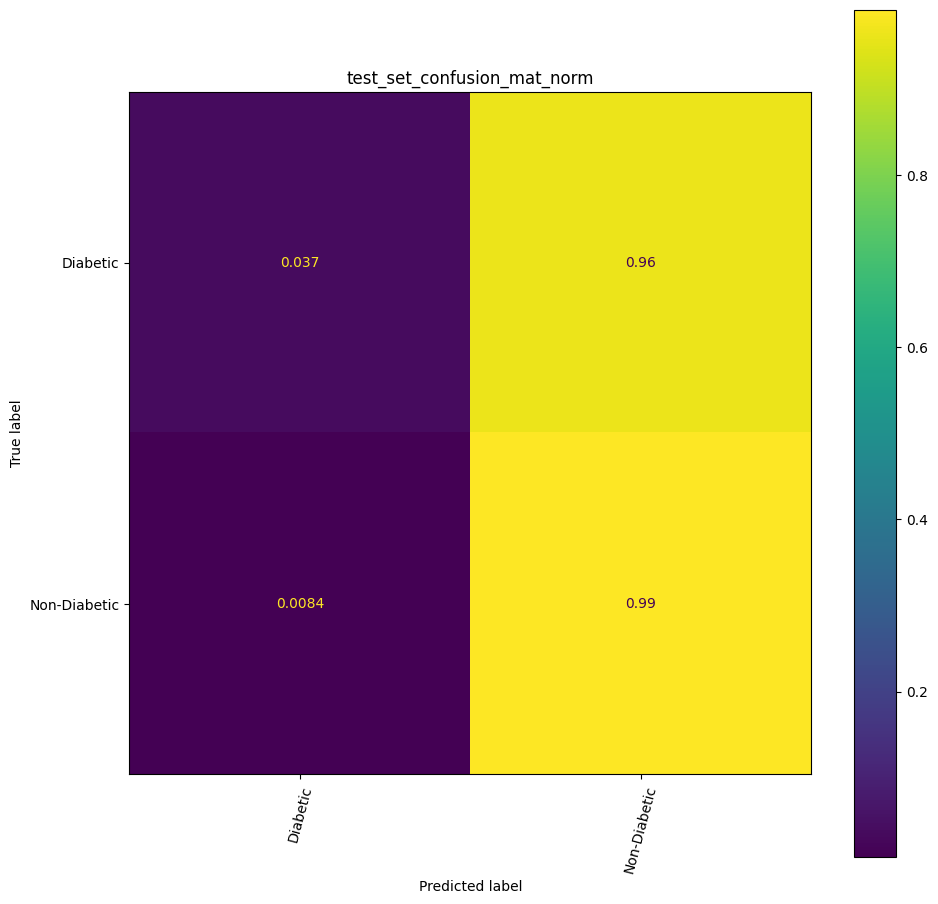

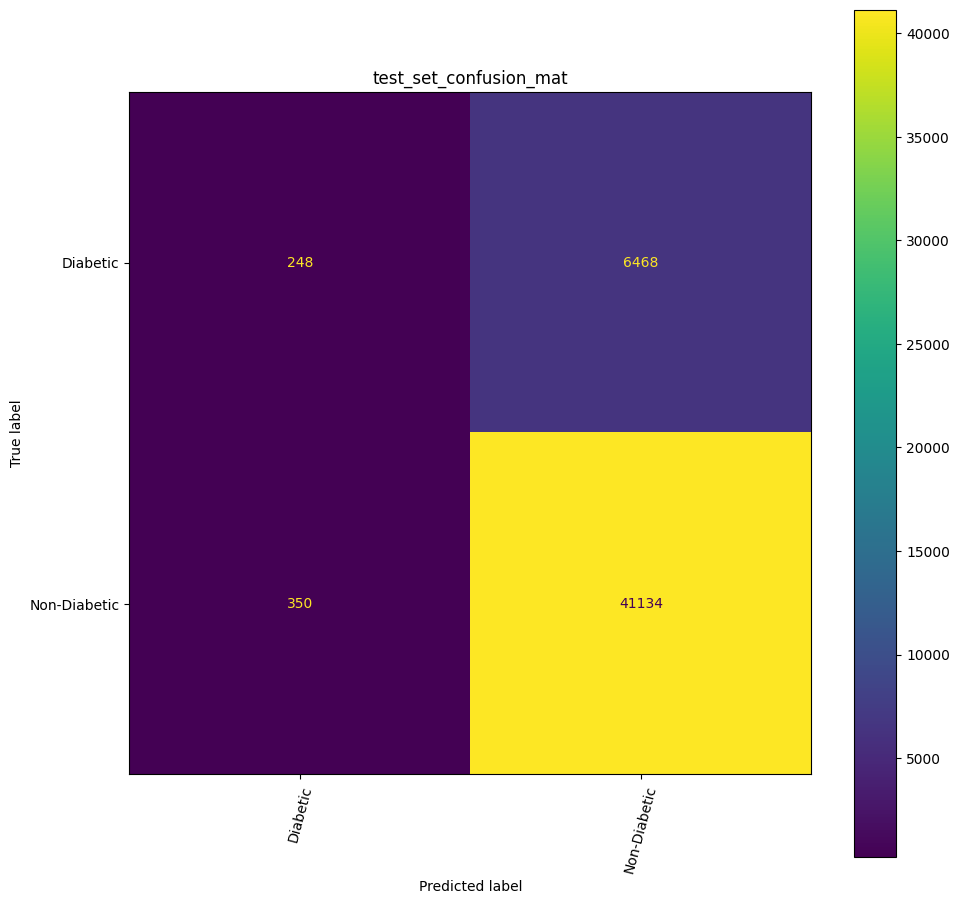

In [26]:
# Calculate performance metrics
training_scores, testing_scores, _ = evaluator.evaluate_model_perf(
    class_encoder=class_encoder, fig_dir=eda_figs_dir
)

print("\nTraining Score:\n")
print(training_scores)

print("\nTesting Score:\n")
print(testing_scores)